In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models.resnet import BasicBlock
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
%config InlineBackend.figure_format = 'retina'


print("PyTorch version:", torch.__version__)

PyTorch version: 2.2.0+cu121


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## Model

In [30]:
# Define SceneClassifier
class SceneClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SceneClassifier, self).__init__()
        self.features = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        num_ftrs = self.features.fc.in_features
        self.features.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.features(x)
        return x

In [4]:
# # Define ResNet-20 model
# class ResNet20(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ResNet20, self).__init__()
#         self.in_planes = 16
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.layer1 = self._make_layer(BasicBlock, 16, 3, stride=1)
#         self.layer2 = self._make_layer(BasicBlock, 32, 3, stride=2)
#         self.layer3 = self._make_layer(BasicBlock, 64, 3, stride=2)
#         self.linear = nn.Linear(64, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = nn.ReLU()(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = nn.functional.avg_pool2d(out, 8)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out
    

# # Construct a MyNet instance on the correct device
# model = ResNet20().to(device)
# # Print nodes in model's graph to check for correctness
# print(model)

In [5]:
# Define transforms for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomCrop(32, padding=4),  # randomly crop the image
    transforms.RandomHorizontalFlip(),  # randomly flip the image horizontally
    transforms.RandomRotation(10),  # randomly rotate the image
    transforms.RandomVerticalFlip(),  # randomly flip the image vertically
])

## Create random samples to train and test

In [6]:
# delete png files in the directory
# import os
# import glob
# for f in glob.glob('data/California/*/*.png'):
#     os.remove(f)
# for f in glob.glob('data/Texas/*/*.png'):
#     os.remove(f)
    

In [7]:
import os
import random
import shutil

def copy_random_files(source_dir, dest_dir, remaining_dir, num_files=100, random_seed=42):
    # Set random seed for reproducibility
    random.seed(random_seed)

    # Get list of files in the source directory
    files = os.listdir(source_dir)
    
    # Randomly select 'num_files' files
    random_files = random.sample(files, min(num_files, len(files)))
    
    # Create destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    if not os.path.exists(remaining_dir):
        os.makedirs(remaining_dir)
    
    # Copy selected files to the destination directory
    for file_name in random_files:
        source_file = os.path.join(source_dir, file_name)
        dest_file = os.path.join(dest_dir, file_name)
        shutil.copy2(source_file, dest_file)
    
    # Copy the remaining files to the remaining directory
    for file_name in files:
        if file_name not in random_files:
            source_file = os.path.join(source_dir, file_name)
            dest_file = os.path.join(remaining_dir, file_name)
            shutil.copy2(source_file, dest_file)




In [8]:
# source_directory = './data/Texas/Yes'
# destination_directory = './data/random/train/Yes'
# remaining_directory = './data/random/test/Yes'

# copy_random_files(source_directory, destination_directory, remaining_directory, num_files=139, random_seed=42)

## Load the data

In [9]:
# Load the dataset
# train_dataset = ImageFolder("data/California", transform=transform)
# test_dataset = ImageFolder("data/Texas", transform=transform)
# train_dataset = ImageFolder("data/Texas", transform=transform)
# test_dataset = ImageFolder("data/California", transform=transform)
train_dataset = ImageFolder("data/random/train", transform=transform)
test_dataset = ImageFolder("data/random/test", transform=transform)

In [10]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
model = SceneClassifier(num_classes=len(train_dataset.classes)).to(device)

In [12]:
# Construct loss function object
criterion = nn.CrossEntropyLoss().to(device)

# Construct optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

## Visualize data

Here we investigate what a batch of our training data looks like.

Notice that our `images` tensor contains the normalized image data, and has shape NxCxHxW, and the `targets` tensor is essentially a list of corresponding target class labels with shape N (batch_size).

images: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) torch.Size([32, 3, 224, 224])
targets: tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


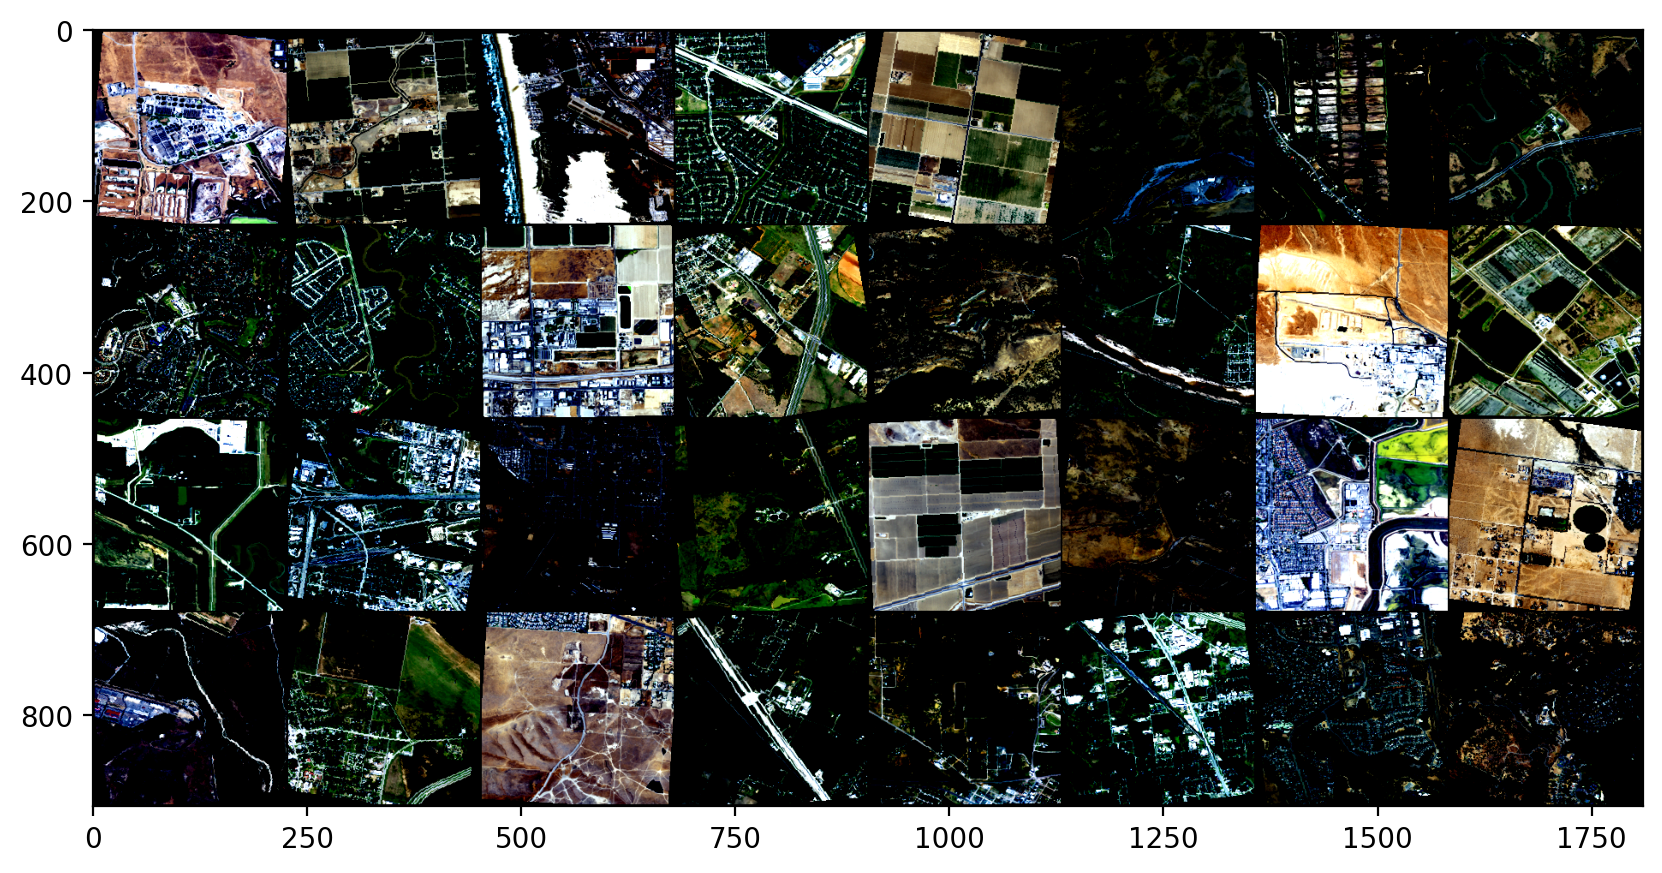

In [13]:
# Grab a batch of training data
images, targets = next(iter(train_loader))
# Print data tensors
print("images:", images[0], images.shape)
print("targets:", targets, targets.shape)

# Plot grid of images
grid_img = torchvision.utils.make_grid(images, 8)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [14]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 386
    Root location: data/random/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomVerticalFlip(p=0.5)
           )

In [15]:
# Get the list of classes (subdirectories)
# path = "./data/California"
path = "./data/random/train"
classes = os.listdir(path)

# Get the list of classes (subdirectories)
classes = [class_name for class_name in os.listdir(path)
           if os.path.isdir(os.path.join(path, class_name))]

# Create a dictionary to store the counts
class_counts = {}

# Iterate over each class directory and count the number of files
for class_name in classes:
    class_path = os.path.join(path, class_name)
    file_count = len(os.listdir(class_path))
    class_counts[class_name] = file_count

# Print the class counts
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of Files: {count}")


Class: No, Number of Files: 159
Class: Yes, Number of Files: 227


In [16]:
# Get the list of classes (subdirectories)
# path = "./data/Texas"
path = "./data/random/test"
classes = os.listdir(path)

# Get the list of classes (subdirectories)
classes = [class_name for class_name in os.listdir(path)
           if os.path.isdir(os.path.join(path, class_name))]

# Create a dictionary to store the counts
class_counts = {}

# Iterate over each class directory and count the number of files
for class_name in classes:
    class_path = os.path.join(path, class_name)
    file_count = len(os.listdir(class_path))
    class_counts[class_name] = file_count

# Print the class counts
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Number of Files: {count}")


Class: No, Number of Files: 2373
Class: Yes, Number of Files: 228


In [17]:
for class_idx, class_name in enumerate(classes):
    print(f"Class Index: {class_idx}, Class Name: {class_name}")

Class Index: 0, Class Name: No
Class Index: 1, Class Name: Yes


## Train the model


Epoch [1/17]


Training loss: 0.7386, Training accuracy: 58.8083
Precision: 0.5472, Recall: 0.5122, F1 Score: 0.4348
Best model saved at: best_model_dev.pth


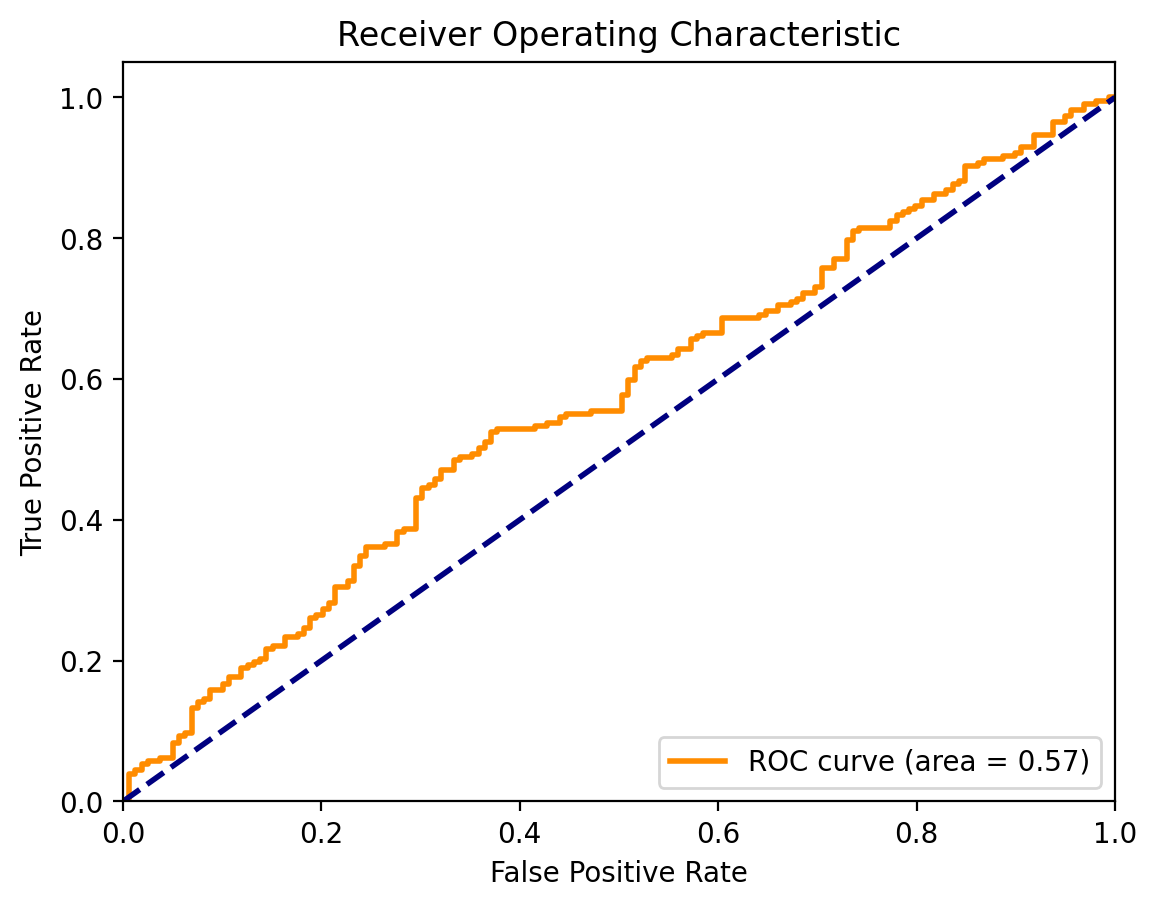


Epoch [2/17]


Training loss: 0.6688, Training accuracy: 61.3990
Precision: 0.5971, Recall: 0.5927, F1 Score: 0.5933
Best model saved at: best_model_dev.pth


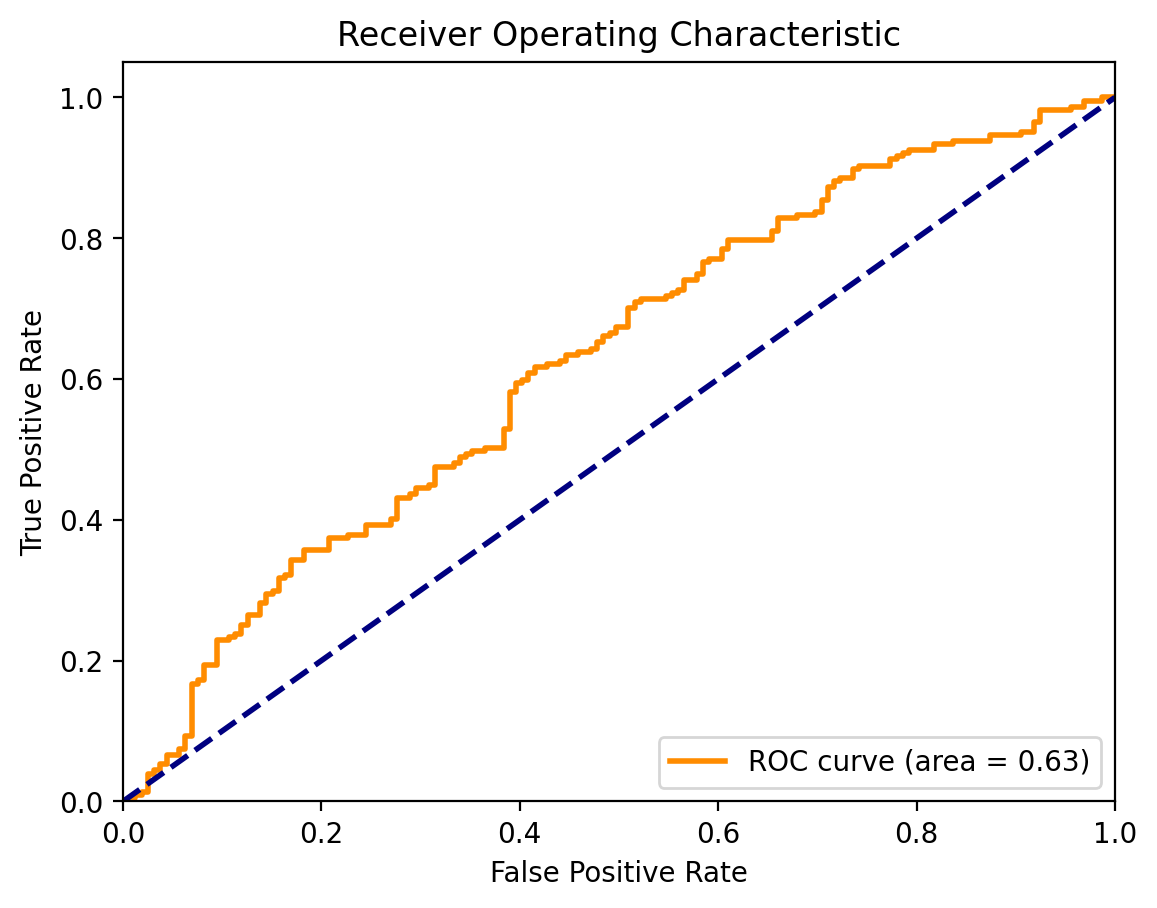


Epoch [3/17]


Training loss: 0.6062, Training accuracy: 65.5440
Precision: 0.6419, Recall: 0.6298, F1 Score: 0.6312
Best model saved at: best_model_dev.pth


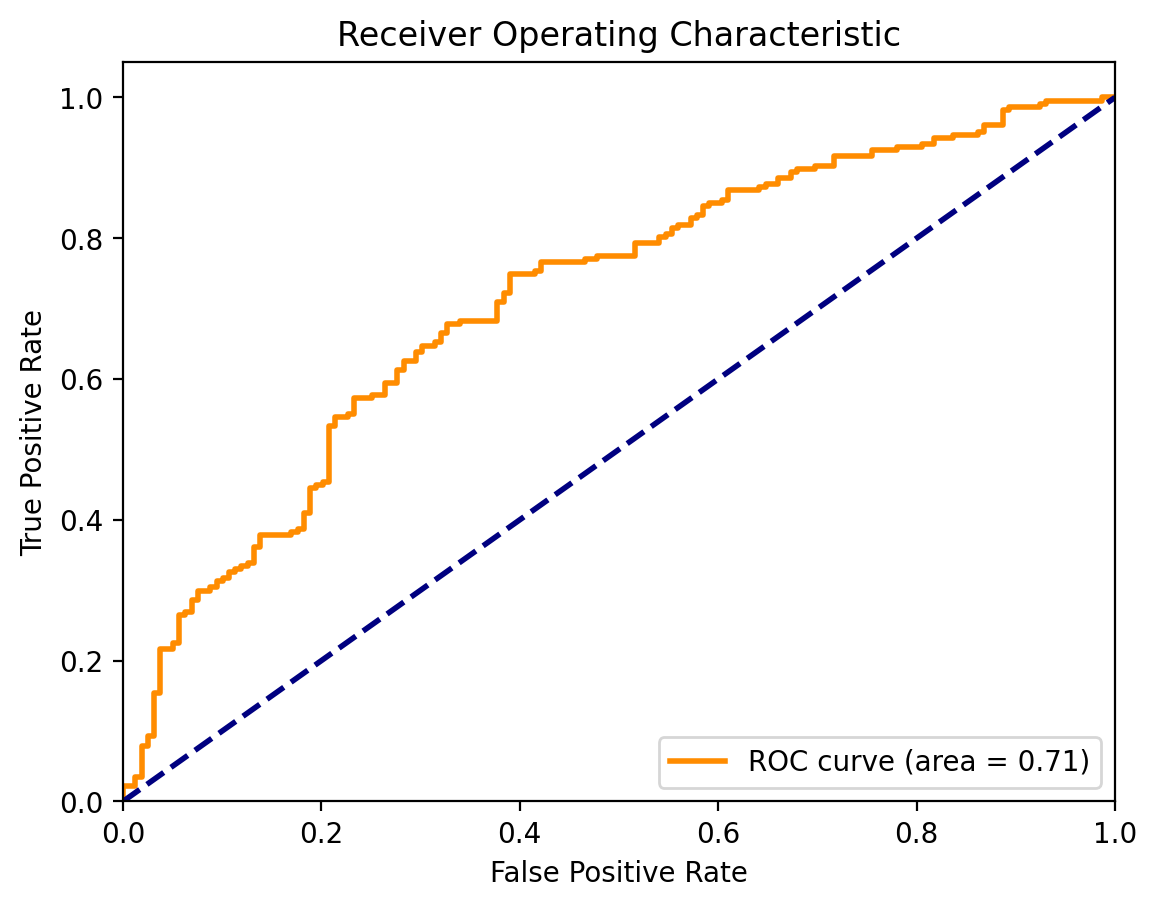


Epoch [4/17]


Training loss: 0.6487, Training accuracy: 67.3575
Precision: 0.6827, Recall: 0.6273, F1 Score: 0.6208


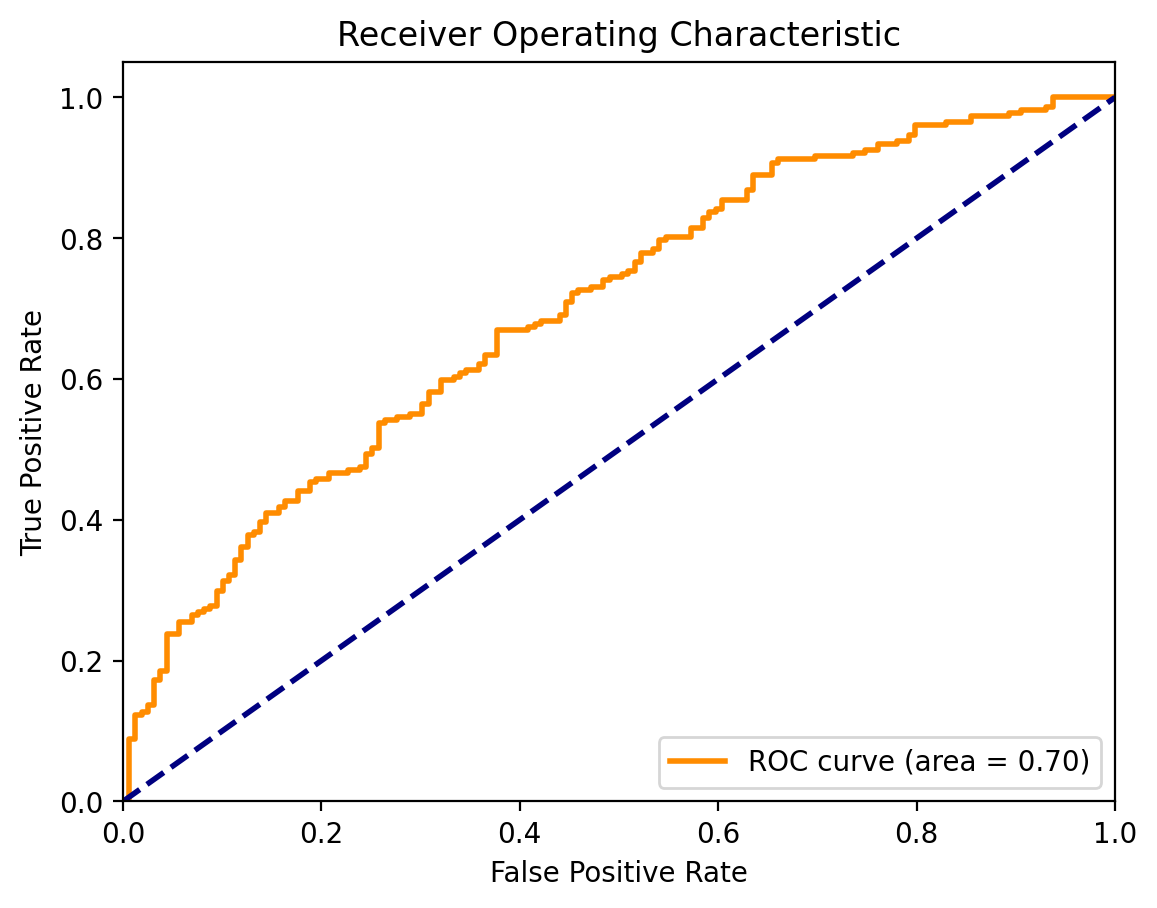


Epoch [5/17]


Training loss: 0.6288, Training accuracy: 66.0622
Precision: 0.6476, Recall: 0.6408, F1 Score: 0.6425
Best model saved at: best_model_dev.pth


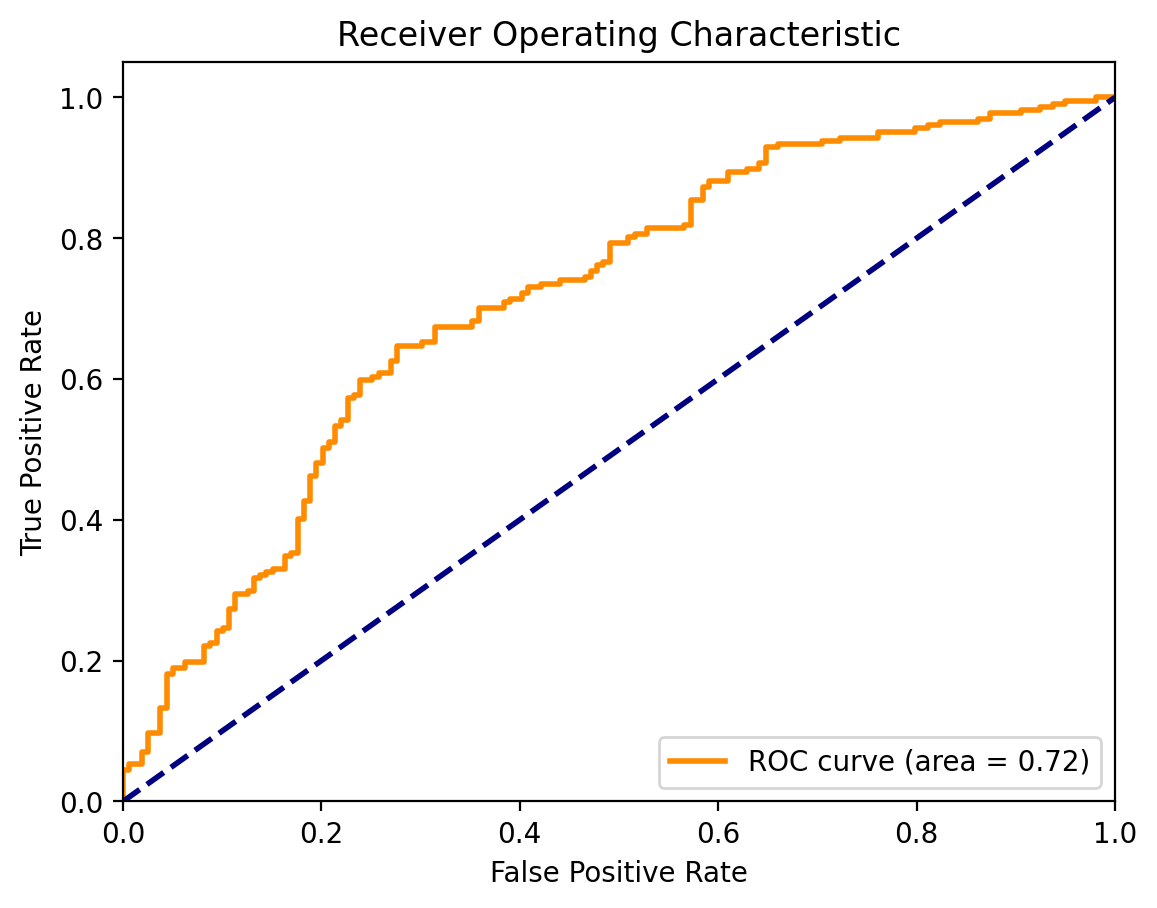


Epoch [6/17]


Training loss: 0.5773, Training accuracy: 72.5389
Precision: 0.7227, Recall: 0.6996, F1 Score: 0.7039
Best model saved at: best_model_dev.pth


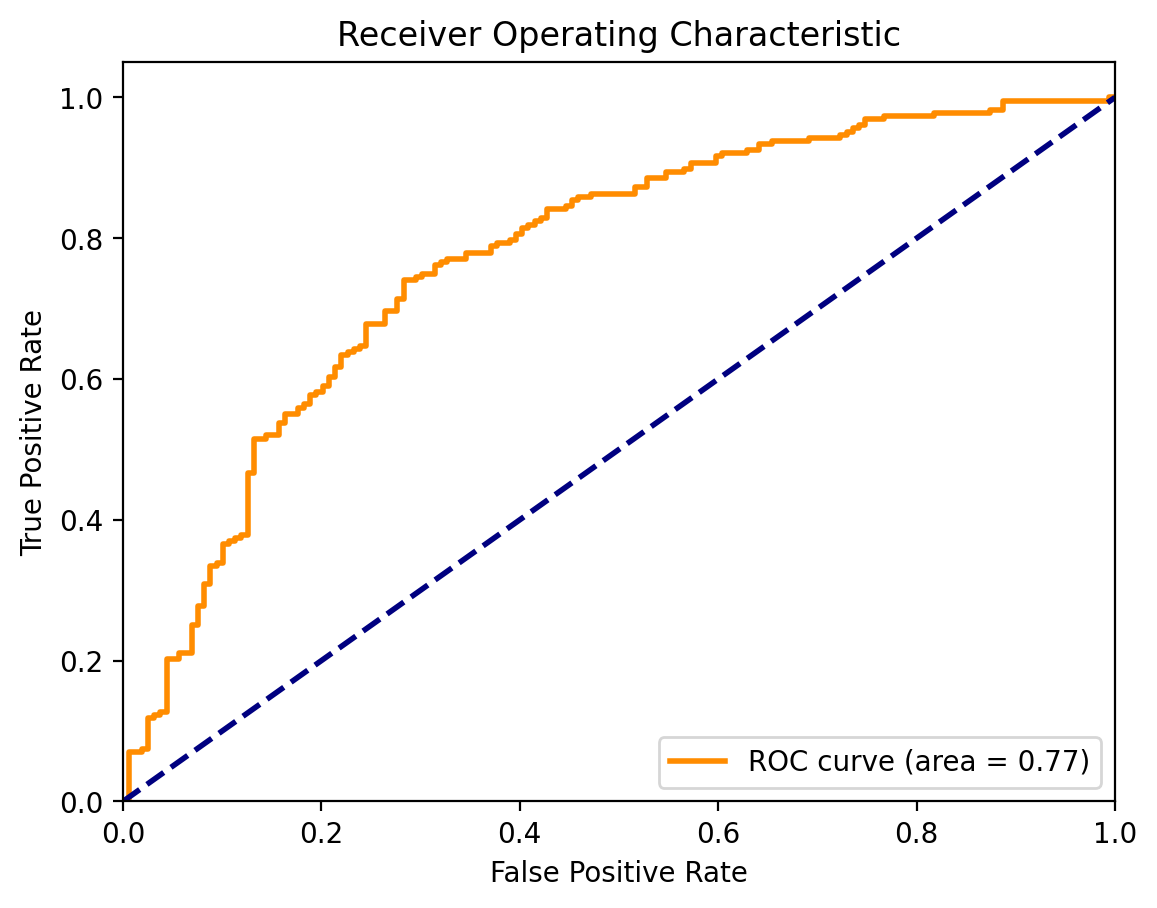


Epoch [7/17]


Training loss: 0.5565, Training accuracy: 74.3523
Precision: 0.7492, Recall: 0.7141, F1 Score: 0.7195
Best model saved at: best_model_dev.pth


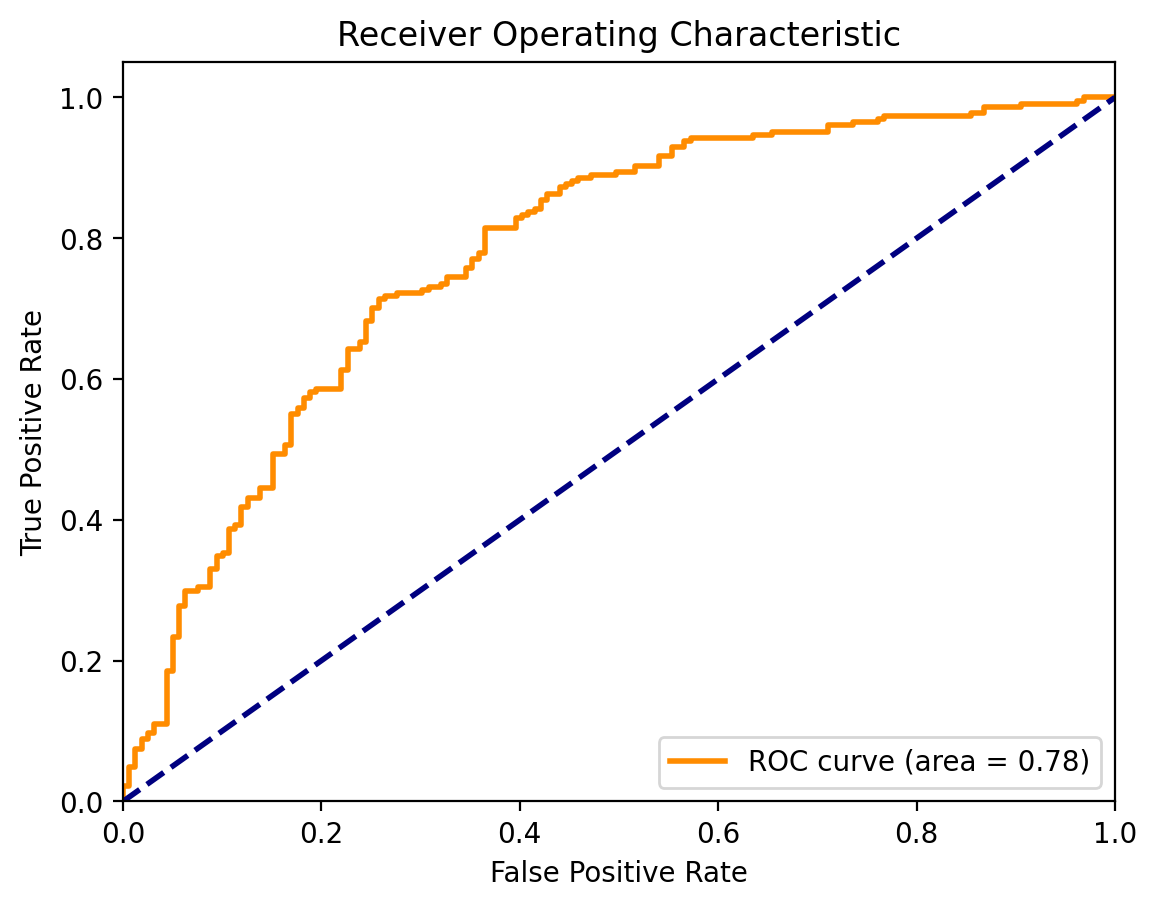


Epoch [8/17]


Training loss: 0.5651, Training accuracy: 74.0933
Precision: 0.7697, Recall: 0.7006, F1 Score: 0.7042


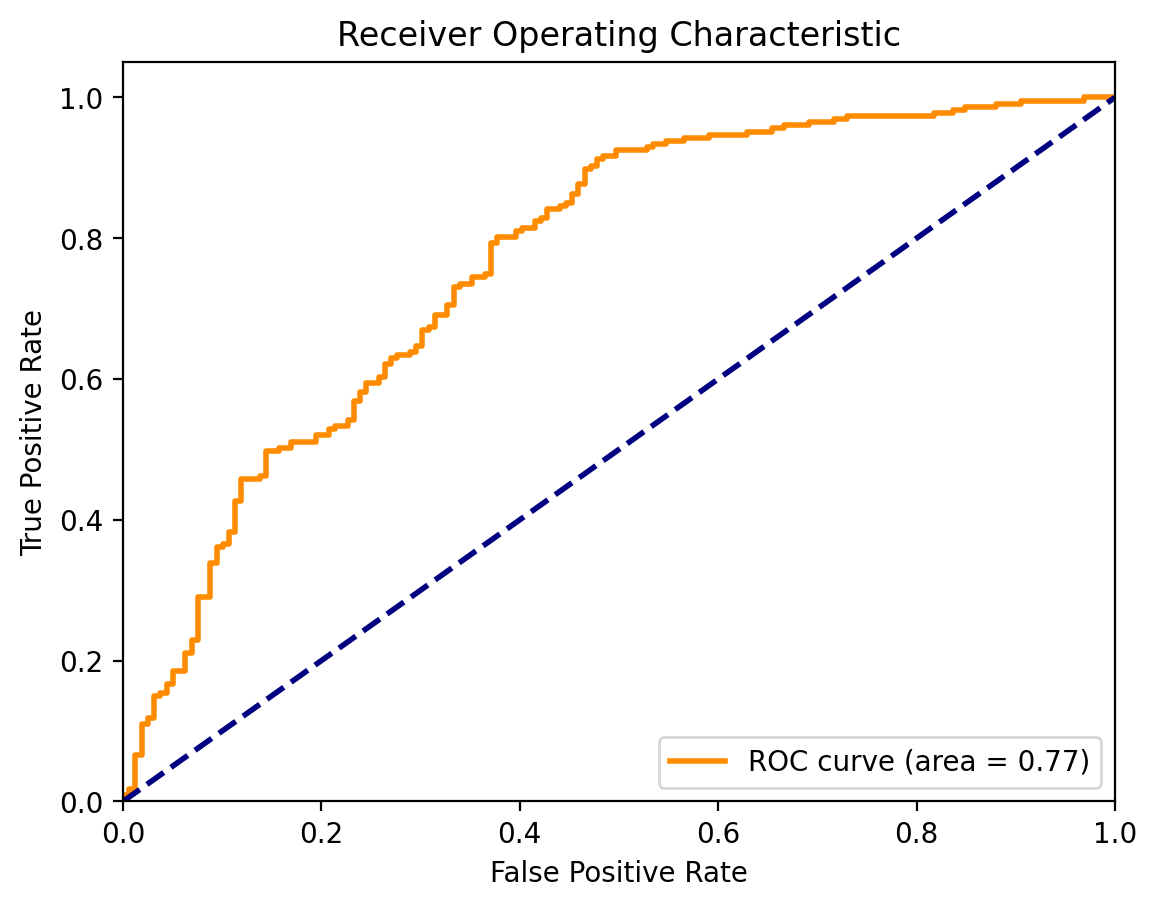


Epoch [9/17]


Training loss: 0.5454, Training accuracy: 72.2798
Precision: 0.7433, Recall: 0.6824, F1 Score: 0.6842


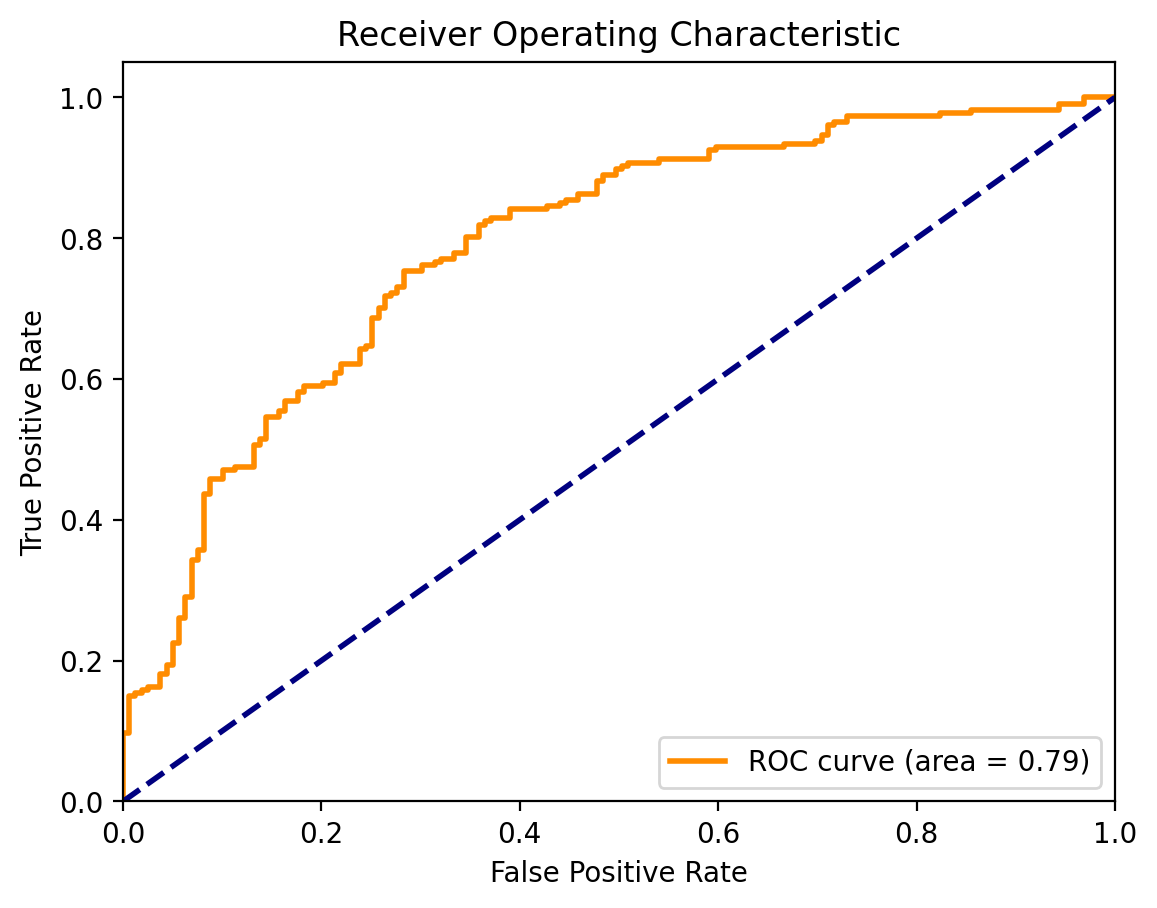


Epoch [10/17]


Training loss: 0.5649, Training accuracy: 75.3886
Precision: 0.7561, Recall: 0.7286, F1 Score: 0.7342
Best model saved at: best_model_dev.pth


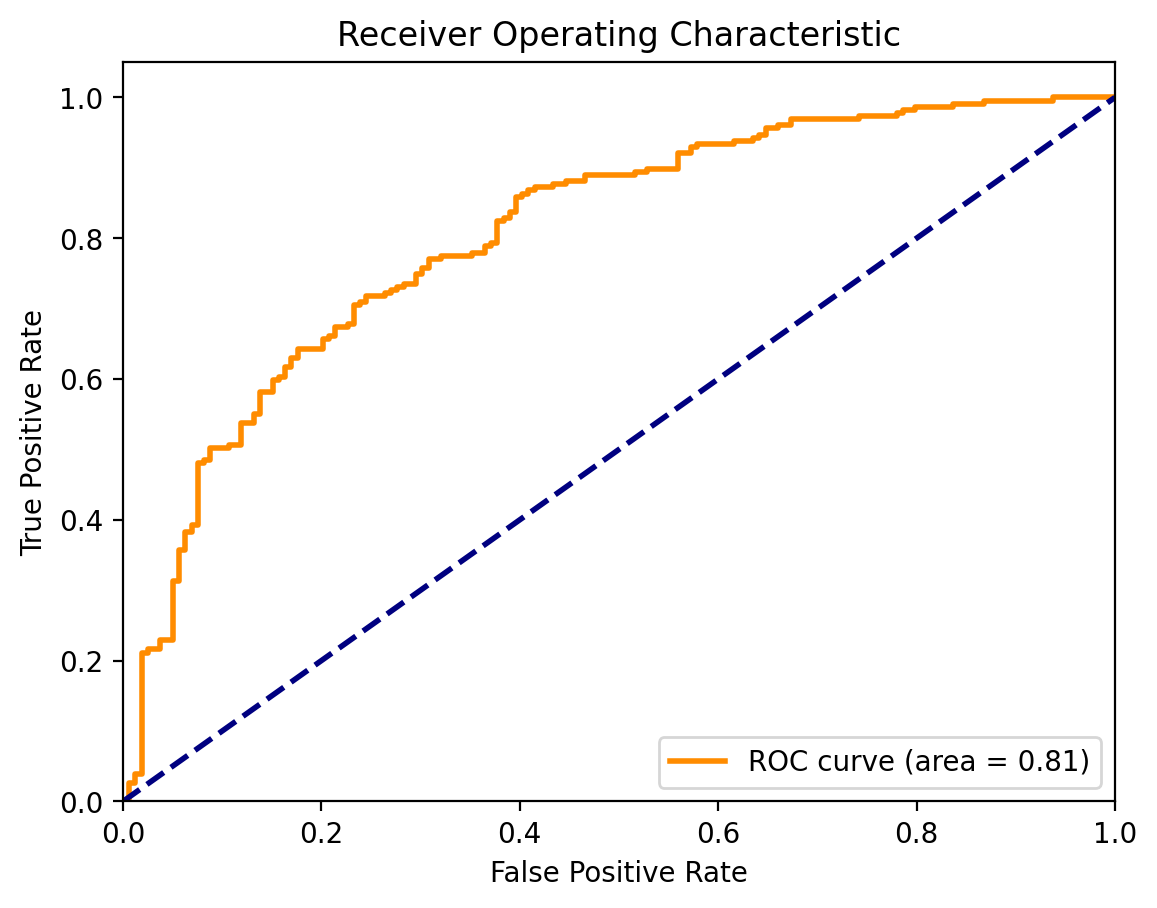


Epoch [11/17]


Training loss: 0.5306, Training accuracy: 75.6477
Precision: 0.7574, Recall: 0.7327, F1 Score: 0.7382
Best model saved at: best_model_dev.pth


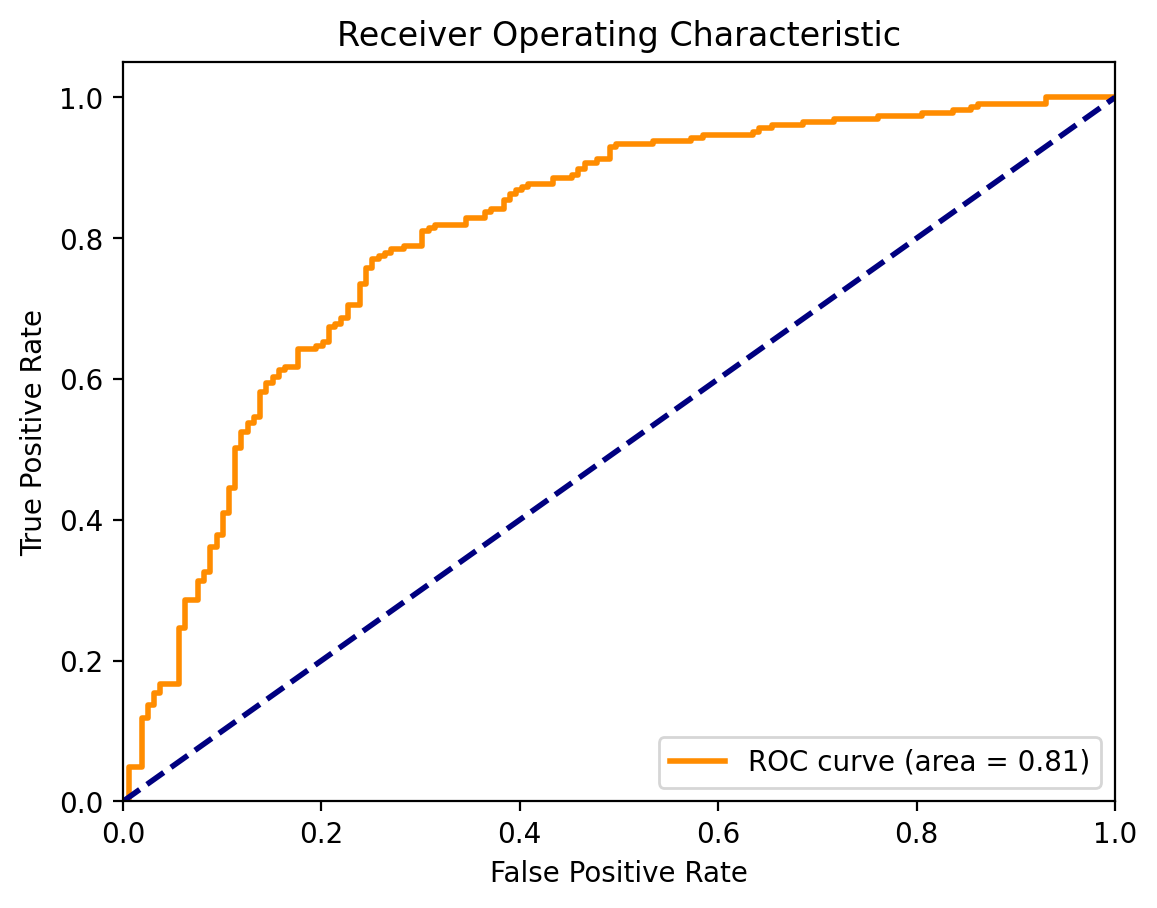


Epoch [12/17]


Training loss: 0.5442, Training accuracy: 71.7617
Precision: 0.7127, Recall: 0.6930, F1 Score: 0.6969


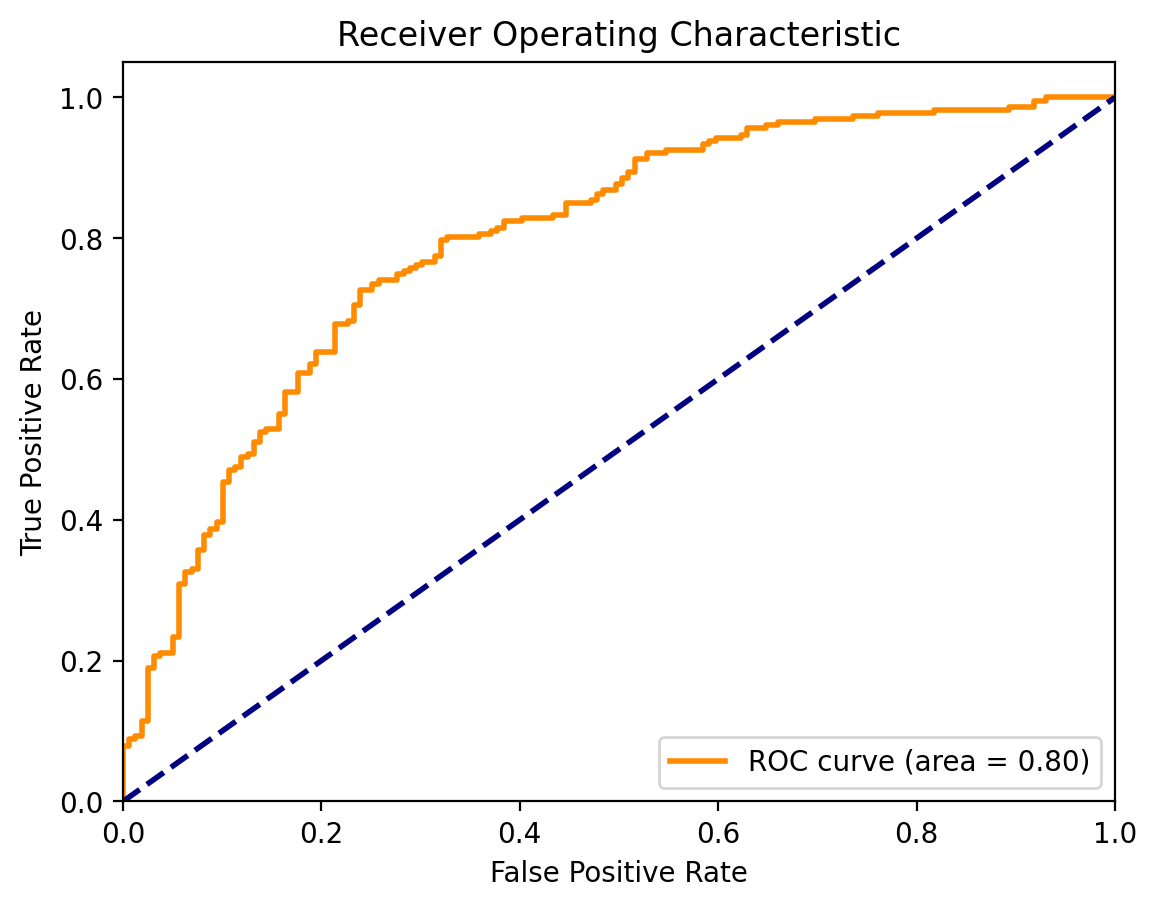


Epoch [13/17]


Training loss: 0.5654, Training accuracy: 74.8705
Precision: 0.7604, Recall: 0.7166, F1 Score: 0.7223


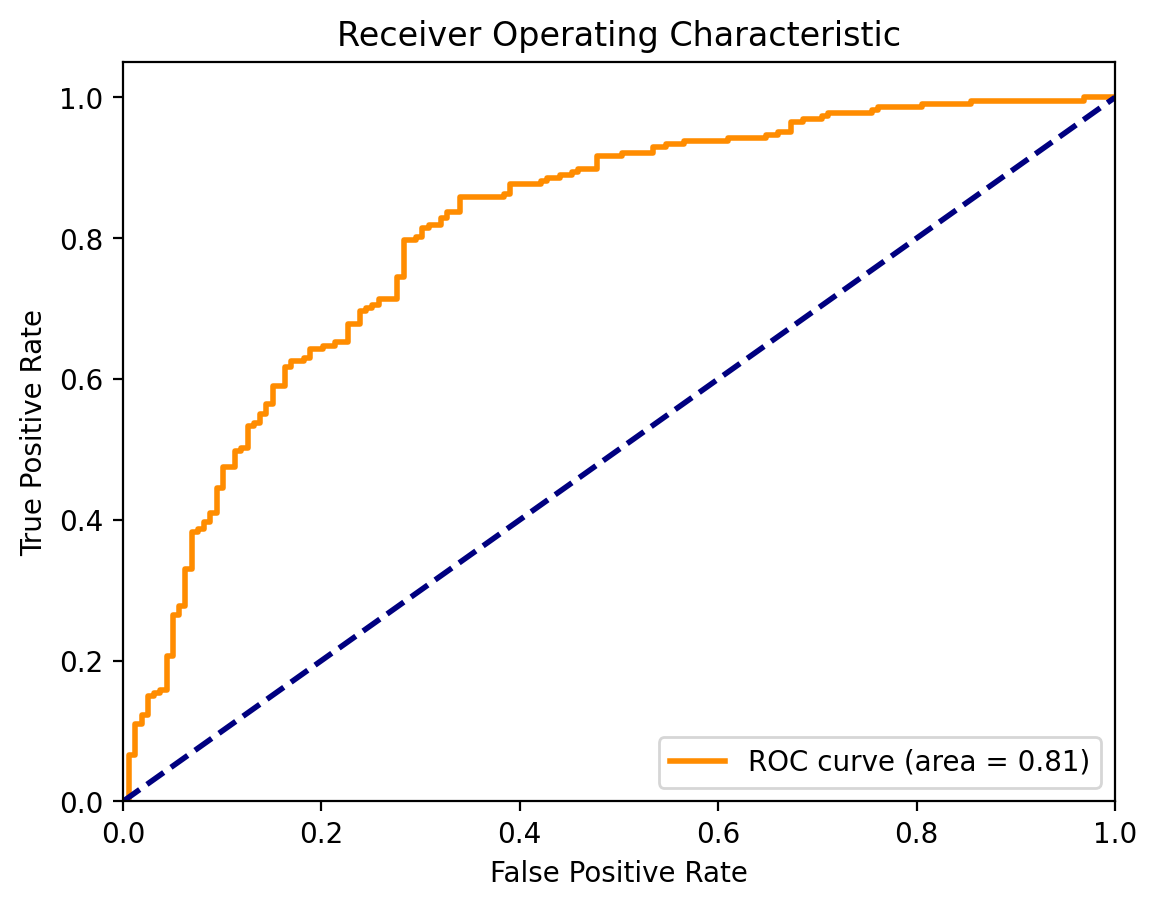


Epoch [14/17]


Training loss: 0.5681, Training accuracy: 76.1658
Precision: 0.7565, Recall: 0.7455, F1 Score: 0.7492
Best model saved at: best_model_dev.pth


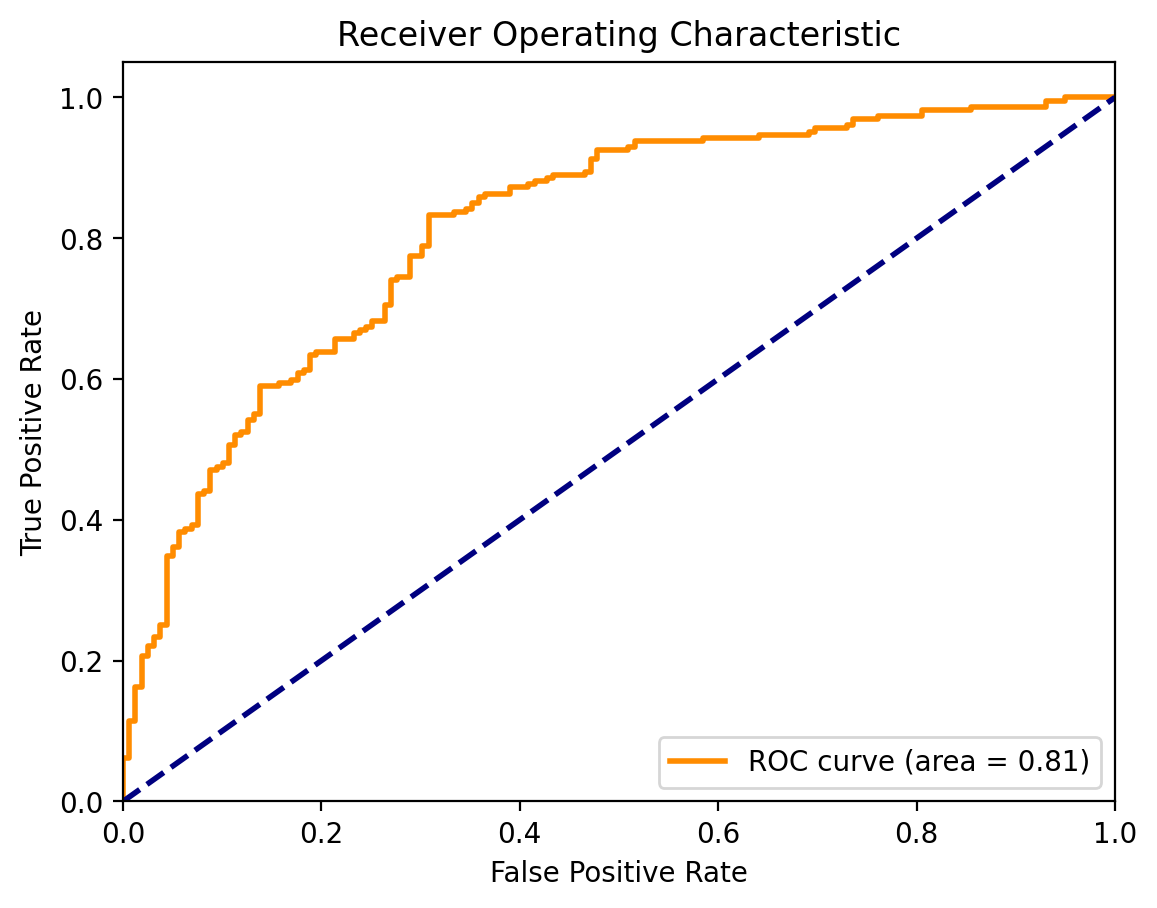


Epoch [15/17]


Training loss: 0.5827, Training accuracy: 73.8342
Precision: 0.7319, Recall: 0.7370, F1 Score: 0.7333


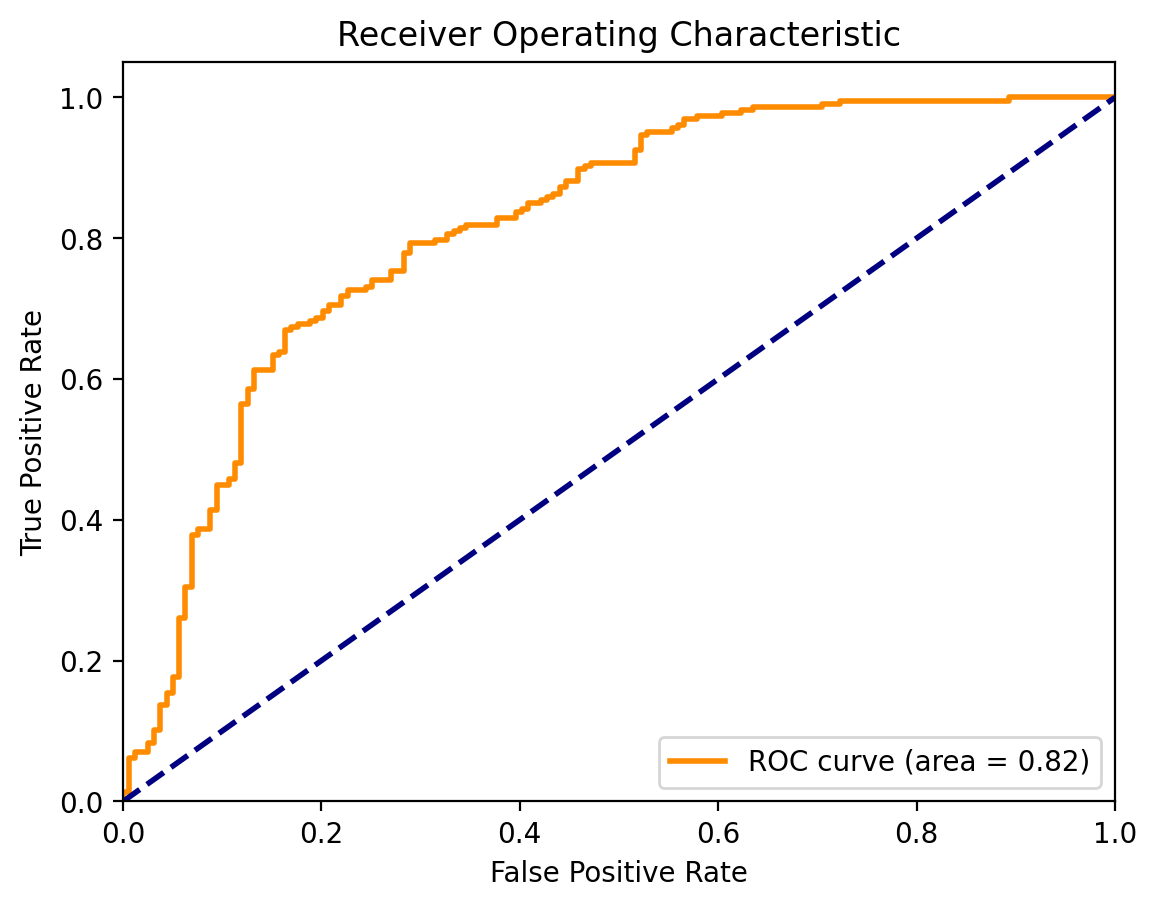


Epoch [16/17]


Training loss: 0.5202, Training accuracy: 79.0155
Precision: 0.7951, Recall: 0.7679, F1 Score: 0.7747
Best model saved at: best_model_dev.pth


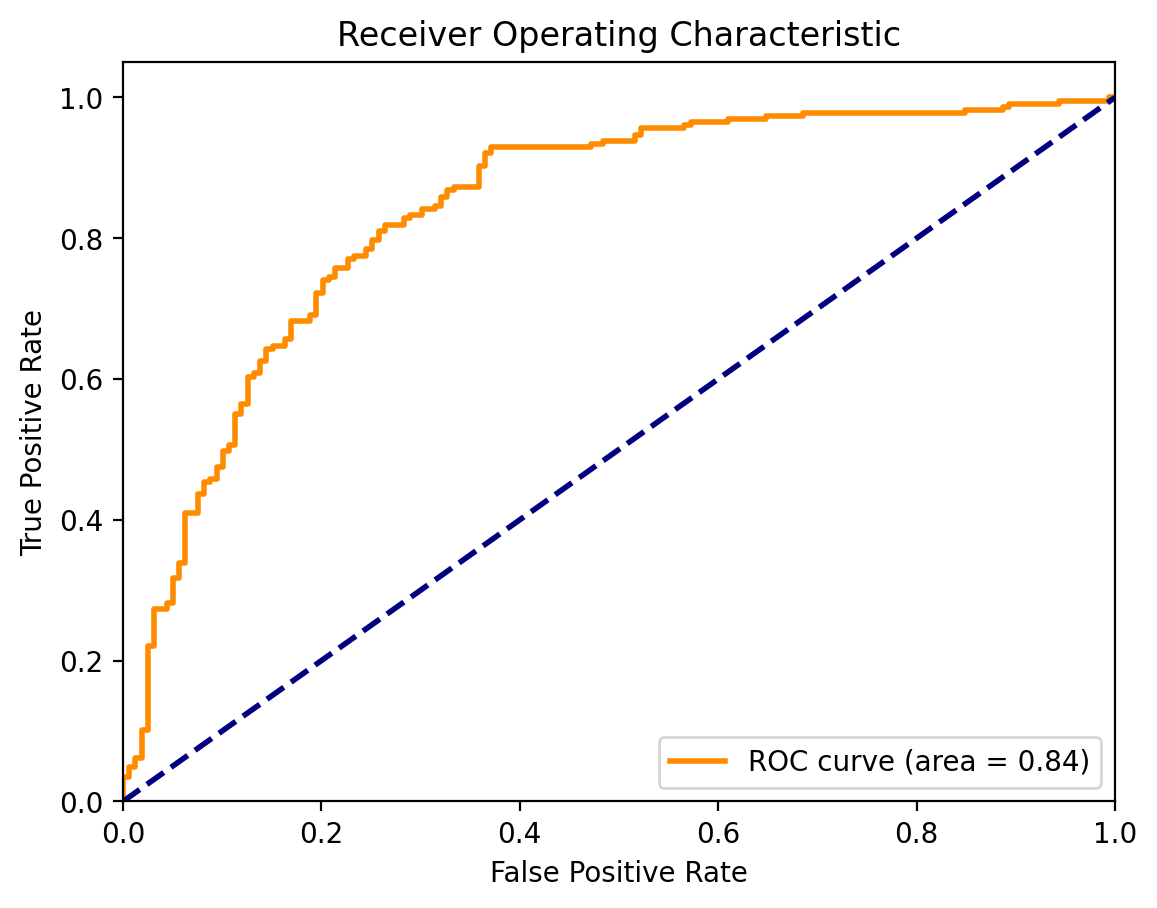


Epoch [17/17]


Training loss: 0.5275, Training accuracy: 77.9793
Precision: 0.7834, Recall: 0.7572, F1 Score: 0.7636


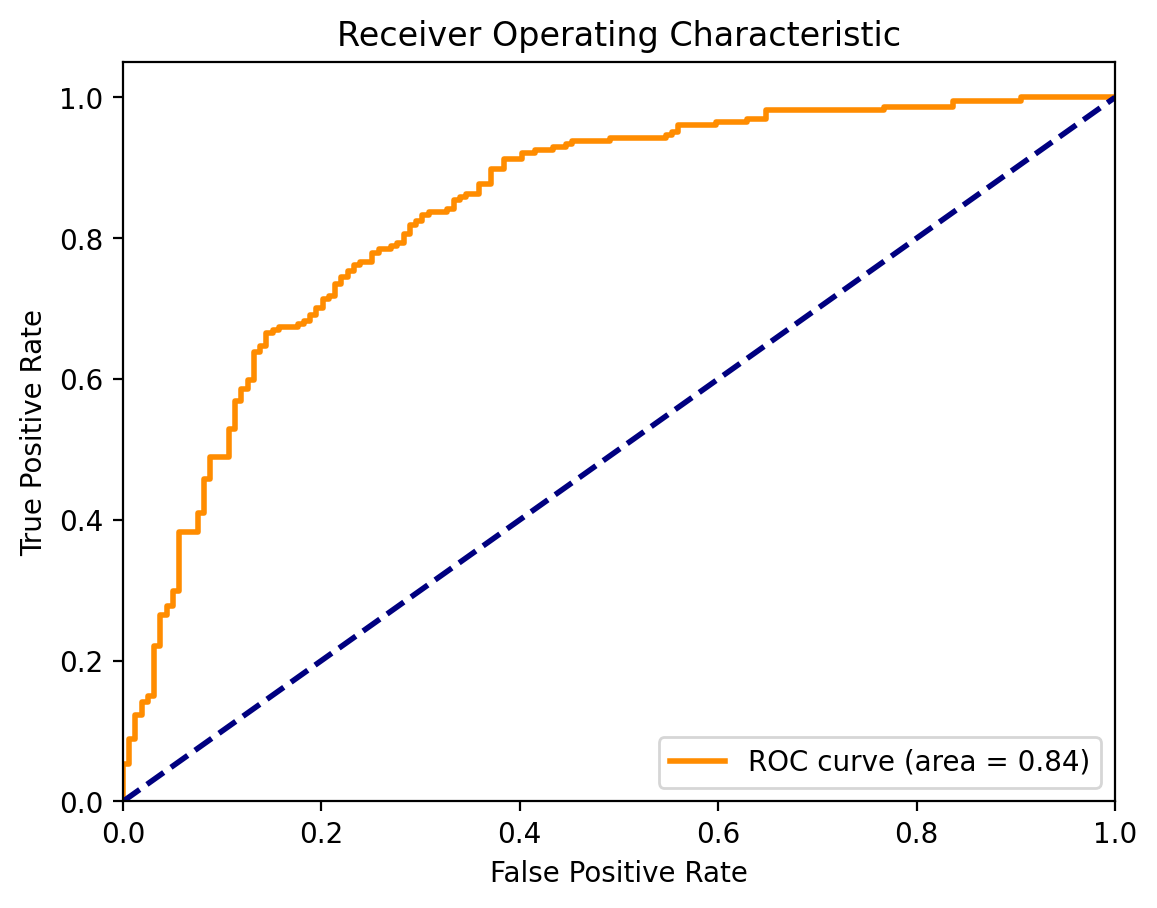

In [18]:
best_recall = 0.0
best_model_path = "best_model_dev.pth"  # Define where to save the best model

epochs = 17

for i in range(1, epochs + 1):
    # Put model in train mode
    model.train()
    print("\nEpoch [{}/{}]".format(i, epochs))

    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0
    loss_list = []
    all_targets = []
    all_predicted = []
    all_probs = []

    # Wrap train_loader with tqdm for the progress bar
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {i}/{epochs}', leave=False)

    # Train the training dataset for 1 epoch.
    for batch_idx, (images, targets) in enumerate(train_loader_iter):
        # Copy inputs to device
        images = images.to(device)
        targets = targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass images through model
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, targets)
        loss_list.append(loss.item())
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        # Append to totals
        total_ims += targets.shape[0]
        total_batches += 1
        total_loss += loss.item()
        total_corrects += predicted.eq(targets).sum().item()
        # Append targets, predicted, and probabilities for ROC curve calculation
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())
        all_probs.extend(nn.functional.softmax(outputs, dim=1).detach().cpu().numpy())

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, acc))

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_targets, all_predicted, average='macro')
    recall = recall_score(all_targets, all_predicted, average='macro')
    f1 = f1_score(all_targets, all_predicted, average='macro')

    print("Precision: %.4f, Recall: %.4f, F1 Score: %.4f" % (precision, recall, f1))

    # Check if current recall is better than the previous best recall
    if recall > best_recall:
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved at:", best_model_path)
        # Update the best recall value
        best_recall = recall

    # Extract probabilities of the positive class
    positive_probs = [prob[1] for prob in all_probs]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_targets, positive_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


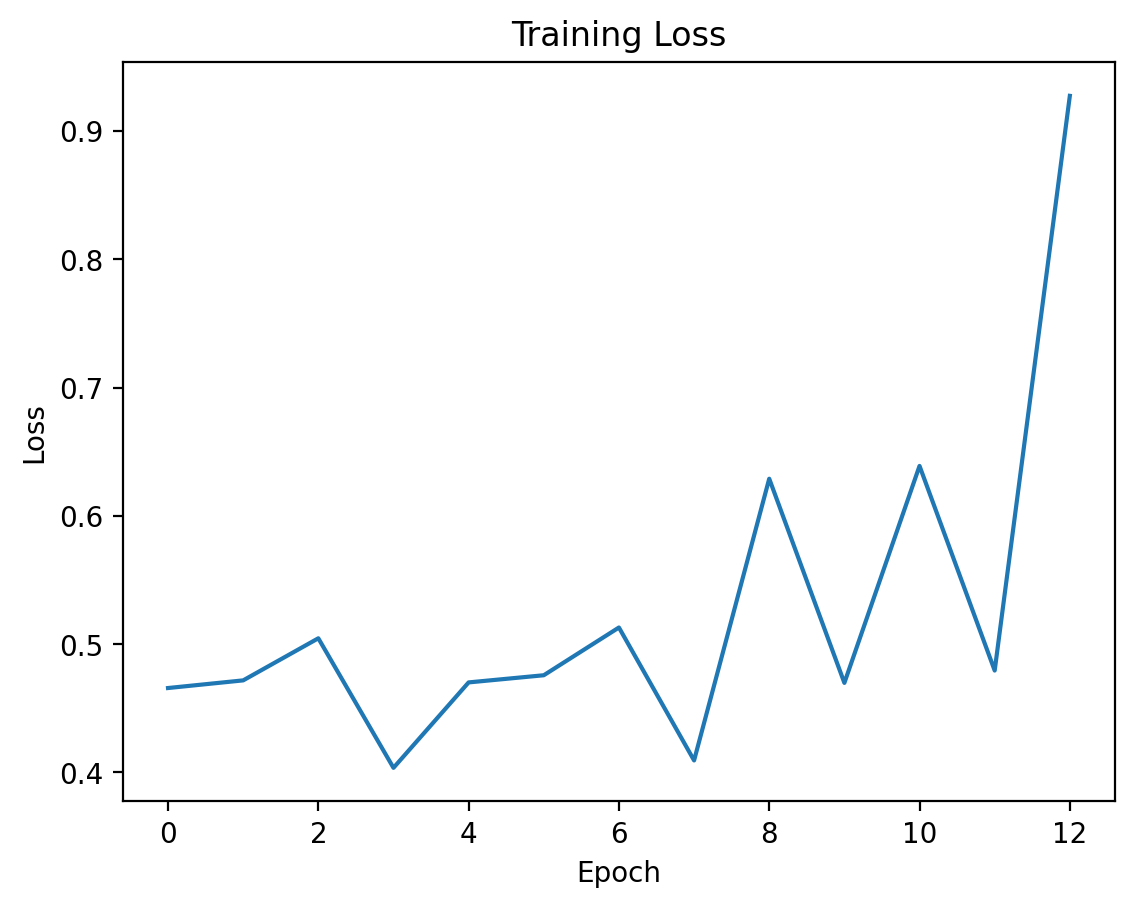

In [20]:
# plot the loss
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Test the model

Now that we have a trained model, we can test its performance on the test set.

To do this we use a similar loop to our training procedure, but we do not need to compute gradients or update the model.

  0%|          | 0/82 [00:00<?, ?it/s]

100%|██████████| 82/82 [05:18<00:00,  3.89s/it]

Test loss: 0.4857, Test accuracy: 79.5848
Precision: 0.6320, Recall: 0.8227, F1 Score: 0.6497


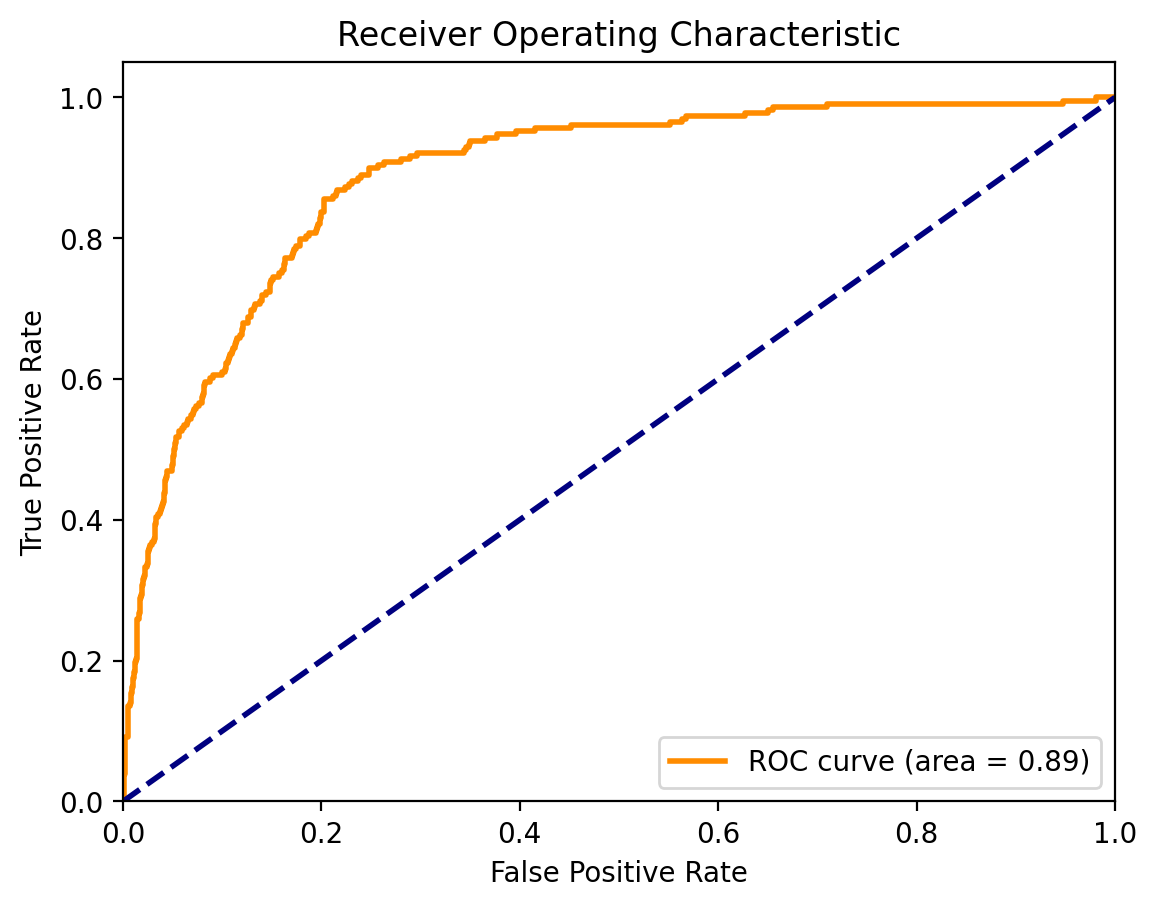

In [26]:
def test_model(model, test_loader, criterion, device):
    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0
    all_targets = []
    all_predicted = []
    all_probs = []

    # Put model in eval mode
    model.eval()

    # Do NOT compute gradients
    with torch.no_grad(), tqdm(total=len(test_loader)) as progress_bar:
        # Run inference on each image in the test set (use batches to make process faster)
        for batch_idx, (images, targets) in enumerate(test_loader):
            # Copy inputs to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass images through model
            outputs = model(images)
            # Compute loss
            loss = criterion(outputs, targets)
            # Calculate correct predictions
            _, predicted = torch.max(outputs, 1)
            # Append to totals
            total_ims += targets.shape[0]
            total_batches += 1
            total_loss += loss.item()
            total_corrects += predicted.eq(targets).sum().item()
            # Append targets, predicted, and probabilities for precision, recall, and ROC curve calculation
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            all_probs.extend(nn.functional.softmax(outputs, dim=1).cpu().numpy())
            progress_bar.update(1)

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0
    print("Test loss: %.4f, Test accuracy: %.4f" % (avg_loss, acc))

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_targets, all_predicted, average='macro')
    recall = recall_score(all_targets, all_predicted, average='macro')
    f1 = f1_score(all_targets, all_predicted, average='macro')

    print("Precision: %.4f, Recall: %.4f, F1 Score: %.4f" % (precision, recall, f1))

    # Extract probabilities of the positive class
    positive_probs = [prob[1] for prob in all_probs]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_targets, positive_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Load the best weights saved during training
best_model_weights_path = best_model_path
model.load_state_dict(torch.load(best_model_weights_path))

# Call test_model
test_model(model, test_loader, criterion, device)


## Saving and loading models

The last basic procedure that we will cover is how to save and load PyTorch models. 

In this example, we wish to save the model to disk to be used for inference later. To do this, we simply use `torch.save` to save the model's `state_dict`, which is a Python dictionary that contains all of the parameters of the module.



For a detailed outline on the many ways to save and load models (e.g., save/load across devices, save/load for finetuning, etc.), see the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html). 

In [ ]:
# Save model
# torch.save(model.state_dict(), "./scene_model_random_dev.pt")

## Predicting with the model with weights

In [32]:
# Load model
model = SceneClassifier(num_classes=len(train_dataset.classes)).to(device)
model.load_state_dict(torch.load(best_model_weights_path))

<All keys matched successfully>

In [ ]:
# for f in glob.glob('data/North Carolina/*/*.png'):
#     os.remove(f)

In [33]:
# # load NC as prediction
# pred = ImageFolder("data/North Carolina", transform=transform)
# pred_loader = DataLoader(pred, batch_size=len(pred), shuffle=False)
# load random test as prediction
pred = ImageFolder("data/random/test", transform=transform)
pred_loader = DataLoader(pred, batch_size=256, shuffle=False)

In [34]:
pred

Dataset ImageFolder
    Number of datapoints: 2601
    Root location: data/random/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomVerticalFlip(p=0.5)
           )

In [37]:
# # Set the model to evaluation mode
# model.eval()

# # Initialize tqdm to track progress
# with tqdm(total=len(pred_loader.dataset), desc='Predicting labels') as progress_bar:
#     # Iterate over the DataLoader in batches
#     for batch_images, _ in pred_loader:
#         # Move batch_images to device
#         batch_images = batch_images.to(device)

#         # Make predictions
#         with torch.no_grad():
#             outputs = model(batch_images).to(device)
#             _, predicted = torch.max(outputs, 1)

#             # Print the number of predictions being made
#             print("Number of predictions:", len(predicted))

#         # Update progress bar
#         progress_bar.update(len(predicted))

In [36]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store filenames and labels
filenames = []
class_labels = []

# Initialize tqdm to track progress
with tqdm(total=len(pred_loader.dataset), desc='Predicting labels') as progress_bar:
    # Iterate over the DataLoader in batches
    for batch_images, _ in pred_loader:
        # Move batch_images to device
        batch_images = batch_images.to(device)

        # Make predictions
        with torch.no_grad():
            outputs = model(batch_images).to(device)
            _, predicted = torch.max(outputs, 1)

        # Convert class indices to class labels
        class_labels.extend([test_dataset.classes[idx] for idx in predicted])

        # Get the filenames for this batch
        batch_filenames = pred_loader.dataset.samples[len(filenames):len(filenames) + len(batch_images)]
        batch_filenames = [os.path.basename(f[0]) for f in batch_filenames]
        filenames.extend(batch_filenames)

        # Update progress bar
        progress_bar.update(len(batch_images))

# Create a dataframe
df = pd.DataFrame({"filename": filenames, "label": class_labels})

# Save to a CSV file
df.to_csv("./data/random/test/predictions.csv", index=False)


Predicting labels: 100%|██████████| 2601/2601 [05:21<00:00,  8.10it/s]


### Set up ground truth csv

In [37]:
# Define the path to the folder containing class folders
random_folder = "./data/random/test"

# Initialize lists to store filenames and ground truth labels
filenames = []
ground_truth_labels = []

# Iterate over class folders
for class_folder in os.listdir(random_folder):
    class_folder_path = os.path.join(random_folder, class_folder)
    if os.path.isdir(class_folder_path):
        # Iterate over files in the class folder
        for filename in os.listdir(class_folder_path):
            # Append filename and ground truth label
            filenames.append(filename)
            ground_truth_labels.append(class_folder)

# Create a DataFrame
df_ground_truth = pd.DataFrame({"filename": filenames, "ground_truth_label": ground_truth_labels})

In [38]:
df_ground_truth.head()

filename ground_truth_label
0   Plant_75118669.tif                 No
1   Plant_76127551.tif                 No
2  Plant_372655141.tif                 No
3   Plant_75119332.tif                 No
4   Plant_82589020.tif                 No

In [39]:
# load prediction and compare against ground truth
df_pred = pd.read_csv("./data/random/test/predictions.csv")

# Merge the DataFrames on the filename column
df_merged = df_ground_truth.merge(df_pred, on="filename")

# Display the first few rows of the merged DataFrame
df_merged.head()

filename ground_truth_label label
0   Plant_75118669.tif                 No    No
1   Plant_76127551.tif                 No    No
2  Plant_372655141.tif                 No    No
3   Plant_75119332.tif                 No    No
4   Plant_82589020.tif                 No    No

In [40]:
# Add a column to indicate if the prediction is correct
df_merged["correct"] = df_merged["ground_truth_label"] == df_merged["label"]

# Display the first few rows of the merged DataFrame
df_merged.head()

filename ground_truth_label label  correct
0   Plant_75118669.tif                 No    No     True
1   Plant_76127551.tif                 No    No     True
2  Plant_372655141.tif                 No    No     True
3   Plant_75119332.tif                 No    No     True
4   Plant_82589020.tif                 No    No     True

In [41]:
# save the merged dataframe
df_merged.to_csv("./data/random/test/predictions_ground_truth.csv", index=False)